In [1]:
from surrogate import Surrogate
from newtons_method import NewtonsMethod
from gramacy import Gramacy
import torch
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats.qmc import LatinHypercube

c:\Users\DeMan01\Documents\uni\masters_thesis\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# recursive function making a list of all points in a hypercube of dim dimensions, and resolution points on each axis
def make_grid(dim=2, lim=(0, 1), resolution=50, grid=None):
    assert dim > 0 and resolution > 0 and lim[0] < lim[1]
    if grid is None:
        grid = torch.empty((resolution ** dim, dim))
    start = 0
    for i in range(resolution):
        end = start + grid.shape[0] // resolution
        if dim > 1:
            make_grid(dim - 1, lim, resolution, grid[start:end, :dim - 1])
        grid[start:end, dim - 1] = lim[0] + (lim[1] - lim[0]) * i / (resolution - 1)
        start = end
    return grid

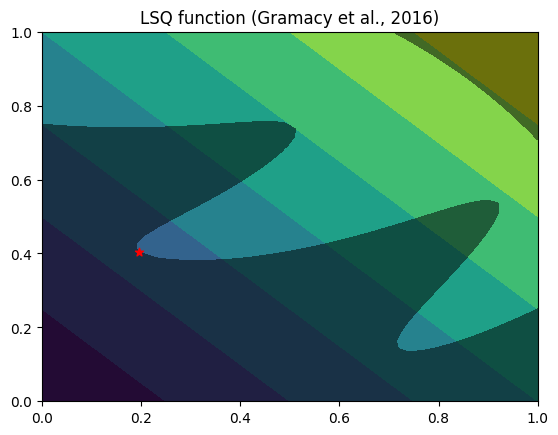

In [5]:
def plot_contours(function, resolution=50, lim=(0, 1), name=None):
    assert resolution > 1
    grid = make_grid(2, lim, resolution)
    x, y = np.linspace(lim[0], lim[1], resolution), np.linspace(lim[0], lim[1], resolution)
    values = function(grid)
    # objective function value
    plt.contourf(x, y, values[:, 0].detach().numpy().reshape((resolution, resolution)))
    # constraints
    for i in range(1, function.n_constraints + 1):
        # shade infeasable area
        plt.contourf(x, y, values[:, i].detach().numpy().reshape((resolution, resolution)), levels=[-np.inf, 0], alpha=0.5, colors=['black', 'white'])
    if hasattr(function, 'optimum') and function.optimum is not None:
        plt.scatter(*function.optimum[0].numpy(), marker="*", color='red')
    if hasattr(function, 'cite') and hasattr(function, 'name'):
        plt.title(f'{function.name} ({function.cite})')
    elif name is not None:
        plt.title(f'{name}')
    plt.show()

f = Gramacy()
plot_contours(f)

torch.float64


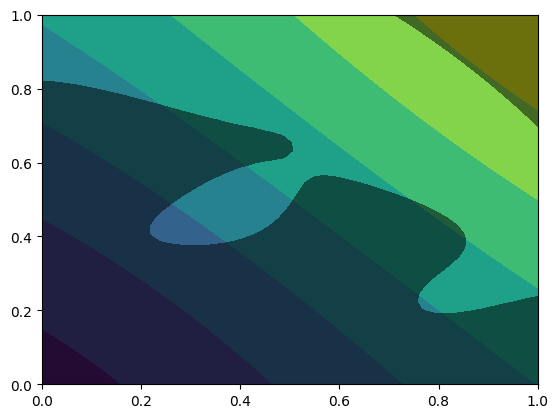

In [ ]:
def make_surrogate(function, n_points=20, sampler=None):
    sampler = LatinHypercube(d=function.x_dim, optimization='lloyd') if sampler is None else sampler
    points_x = torch.tensor(sampler.random(n_points), dtype=torch.double)
    points_y = function(points_x)
    return Surrogate(points_x, points_y)

sur = make_surrogate(f)
plot_contours(sur)